This is an image classification problem with multiple classes. Original data is taken from https://www.kaggle.com/alessiocorrado99/animals10

In [ ]:
import tensorflow as tf
import pickle
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



print(tf.__version__)

2.7.0


In [ ]:
# original data classes are not in English, this is a helper method to translate them to English
from translate import *
translate["ragno"] = "spider" # there was a missing key

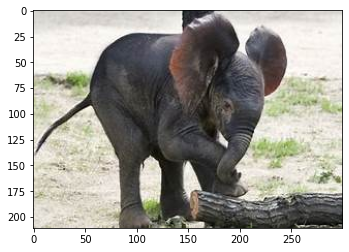

(211, 300, 3)

In [ ]:
DATADIR = './raw-img'

CATEGORIES_ORIG = []
CATEGORIES = []

for cat in os.listdir(DATADIR):
    CATEGORIES_ORIG.append(cat)
    translated_cat = translate.get(cat)
    if translated_cat is None:
      print("{} is not found in translate".format(cat))
    CATEGORIES.append(translate.get(cat))
    
for cat in CATEGORIES_ORIG:
    path = os.path.join(DATADIR, cat)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

img_array.shape

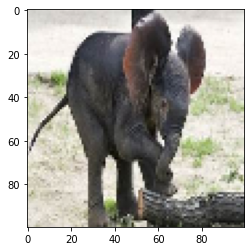

In [ ]:
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
features = []
labels = []

for idx, cat in enumerate(CATEGORIES_ORIG):
    path = os.path.join(DATADIR, cat)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        
        features.append(new_array)
        labels.append(idx)

In [ ]:
features = np.array(features)
labels = np.array(labels).reshape(-1, 1)

In [ ]:
features, labels = shuffle(features, labels)

butterfly
farfalla


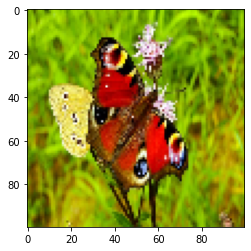

In [ ]:
random_idx = np.random.randint(low=0, high=features.shape[0])

lbl = labels[random_idx][0]
print(CATEGORIES[lbl])
print(CATEGORIES_ORIG[lbl])
plt.imshow(cv2.cvtColor(features[random_idx], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Save the data to bypass preprocessing steps in the future
pickle_out = open("X.pickle", "wb")
pickle.dump(features, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(labels, pickle_out)
pickle_out.close()

In [ ]:
X_orig = pickle.load(open("X.pickle", "rb"))
y_orig = pickle.load(open("y.pickle", "rb"))

In [ ]:
X = (X_orig / 255.0).astype(np.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_orig, test_size=0.3, random_state=42)
##X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
#print(X_validation.shape)
print(y_train.shape)
print(y_test.shape)
#print(y_validation.shape)

(18325, 70, 70, 3)
(3927, 70, 70, 3)
(3927, 70, 70, 3)
(18325, 1)
(3927, 1)
(3927, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation=tf.nn.relu, kernel_initializer="he_normal", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=X.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation=tf.nn.relu, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), kernel_initializer="he_normal"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation=tf.nn.relu, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), kernel_initializer="he_normal"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same", activation=tf.nn.relu, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), kernel_initializer="he_normal"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation=tf.nn.relu))
model.add(Dense(len(CATEGORIES), activation=tf.nn.softmax))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

In [ ]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.3)

model.fit(X, to_categorical(y_orig),
          batch_size=8, epochs=20, 
          validation_split=0.3,
          callbacks=[reduce_lr_on_plateau])

Epoch 1/20
2291/2291 [==============================] - 29s 9ms/step - loss: 1.7586 - accuracy: 0.4203 - val_loss: 1.5104 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 2/20
2291/2291 [==============================] - 16s 7ms/step - loss: 1.2788 - accuracy: 0.5908 - val_loss: 1.2489 - val_accuracy: 0.5936 - lr: 0.0010
Epoch 3/20
2291/2291 [==============================] - 18s 8ms/step - loss: 1.0478 - accuracy: 0.6732 - val_loss: 1.1888 - val_accuracy: 0.6318 - lr: 0.0010
Epoch 4/20
2291/2291 [==============================] - 18s 8ms/step - loss: 0.8615 - accuracy: 0.7389 - val_loss: 1.3389 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 5/20
2291/2291 [==============================] - 18s 8ms/step - loss: 0.7111 - accuracy: 0.7923 - val_loss: 1.2747 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 6/20
2291/2291 [==============================] - 16s 7ms/step - loss: 0.5674 - accuracy: 0.8456 - val_loss: 1.4195 - val_accuracy: 0.6506 - lr: 0.0010
Epoch 7/20
2291/2291 [==============================